In [1]:
import pandas as pd
import json
import re
import nltk
from nltk import tokenize
import gensim
from fuzzywuzzy import fuzz
from pymongo import MongoClient
import emoji

<h1><font color='red' size>1. Leitura dos dados:</font></h1>

In [2]:
# lendo as notícias do dataset em csv
dados = pd.read_csv("dados/articles.csv")

In [3]:
dados.head()

,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",2017-09-10,mercado,NaN,http://www1.folha.uol.com.br/mercado/2017/10/1...


In [4]:
# salvando uma lista com os valores únicos da coluna categiria
categorias = dados.category.unique()

# exibindo a quantidade de notícias por categoria
print(f'{"Categoria":{30}} {"Notícias":>{10}}')
for categoria in categorias:
    quantidade = len(dados.loc[dados['category'] == categoria])
    print(f'{categoria:{30}} {quantidade:->{10}}')

Categoria                        Notícias
poder                          -----22022
ilustrada                      -----16345
mercado                        -----20970
mundo                          -----17130
esporte                        -----19730
tec                            ------2260
cotidiano                      -----16967
ambiente                       -------491
equilibrioesaude               ------1312
sobretudo                      ------1057
colunas                        -----21622
educacao                       ------2118
tv                             ------2142
banco-de-dados                 --------64
opiniao                        ------4525
ciencia                        ------1335
paineldoleitor                 ------4011
saopaulo                       ------3955
ilustrissima                   ------1411
seminariosfolha                -------379
turismo                        ------1903
empreendedorsocial             -------841
serafina                       ---

In [5]:
# selecionando as notícias da categoria comida
comida = dados.loc[dados['category'] == "comida"]
comida.head()

,title,text,date,category,subcategory,link
12786,"Morre o chef Alain Senderens, um dos precursor...","Morreu no ultimo domingo, 25, em sua casa em C...",2017-06-27,comida,NaN,http://www1.folha.uol.com.br/comida/2017/06/18...
22966,"Eleven Madison Park, de NY, é eleito o melhor ...",O nova-iorquino Eleven Madison Park foi nomead...,2017-05-04,comida,NaN,http://www1.folha.uol.com.br/comida/2017/04/18...
23456,Nada de arroz e feijão: saiba qual alimento un...,"Nem arroz, muito menos o feijão. Pergunte ao c...",2017-01-04,comida,NaN,http://www1.folha.uol.com.br/comida/2017/04/18...
25454,Como evitar comer carne estragada? Confira dicas,"Nesta sexta-feira (17), a Polícia Federal defl...",2017-03-17,comida,NaN,http://www1.folha.uol.com.br/comida/2017/03/18...
53641,Fazenda na Espanha produz foie gras de 'gansos...,Os espanhóis Eduardo Sousa e Diego Labourdette...,2016-08-22,comida,NaN,http://www1.folha.uol.com.br/comida/2016/08/18...


In [6]:
# salvando uma lista com as notícias da categoria comida
textos = comida['text'].dropna().tolist() + comida['title'].dropna().tolist()

In [7]:
# criando estrutura de dados para salvar os exemplos de treinamento do chatbot
dicionario_intencoes = {}

# lendo o arquivo JSON de todo o corpus de conhecimento do chatbot
with open("dados/skill-Bot-restaurante.json", encoding='utf-8') as json_file:
    dadados_json = json.load(json_file)
    # selecionamento as intenções do corpus de conhecimento
    intencoes = dadados_json.get("intents")
    for intencao in intencoes:
        nova_chave = {intencao.get("intent") : [exp.get("text") for exp in intencao.get("examples")]}
        # anexando os exemplos e cada uma das intenções à estrutura de dados
        dicionario_intencoes.update(nova_chave)

# anexando os exemplos à lista de notícias da categoria comida
for x in dicionario_intencoes:
    textos += dicionario_intencoes.get(x)
    
print(f"Quantidade de frases no dataset: {len(textos)}")

Quantidade de frases no dataset: 1706


In [8]:
# iniciando conexão com o banco de dados
client = MongoClient('localhost', 27017)

# instanciando a coleção de tweets sobre comida
db = client.twitterdb3
col = db.tweets

In [9]:
# criando um dataset com dados retornados da coleção
tweets = [item["text"] for item in col.find()]

<h1><font color='red' size>2. Normalização do texto:</font></h1>

In [10]:
tweets_limpos = []

# compilando regex para identificar nomes de usuário e urls nos tweets
nome_usuario_pattern = re.compile('\@\w+')
url_pattern = re.compile('\bhttps?:\/\/.*\b')
risada_pattern = re.compile('\bk+\b')

# instanciando objeto com a lista de emojis
emojis = emoji.UNICODE_EMOJI

# para cada tweet
for tweet in tweets:
    # removendo os termos 'rt', nome de usuário, urls e outros padrões comuns no texto do tweet 
    texto_tweet = tweet.lower()
    texto_tweet = texto_tweet.replace('rt','')
    texto_tweet = re.sub(nome_usuario_pattern, "", texto_tweet)
    texto_tweet = re.sub(url_pattern, "", texto_tweet)
    texto_tweet = re.sub(risada_pattern, "", texto_tweet)
    
    # removendo os emojis do texto do tweet
    letras_texto = [str for str in texto_tweet]
    lista_emojis = [c for c in letras_texto if c in emojis]
    texto_tweet = ' '.join([str for str in texto_tweet.split() if not any(i in str for i in lista_emojis)])
    
    # anexando o tweet limpo à lista
    tweets_limpos.append(texto_tweet)

print(f"Quantidade total de tweets: {len(tweets_limpos)}")

# removendo tweets duplicados da lista de tweets limpos
tweets_limpos = list(dict.fromkeys(tweets_limpos))
print(f"Quantidade de tweets únicos: {len(tweets_limpos)}")

# anexando os tweets limpos ao dataset
textos += tweets_limpos
print(f"Quantidade de frases no dataset: {len(textos)}")

Quantidade total de tweets: 649518
Quantidade de tweets únicos: 363042
Quantidade de frases no dataset: 364748


In [11]:
# inicializando os objetos da biblíoteca NLTK e spaCy para fazer a tokenização, remoção
# das palavras contidas na lista de stopwords e obtenção de sua versão 'stemmizada'
sent_tokenizer = nltk.data.load('tokenizers/punkt/portuguese.pickle')
stopwords = nltk.corpus.stopwords.words('portuguese')
stemmer = nltk.stem.SnowballStemmer('portuguese')

# compilando regex para identificar caracteres que não sejam palavras
regex = re.compile('\W')

# declarando lista que guardará as senteças tokenizadas das notícias
sentencas_tokenizadas = []

## descomentar para fazer uma demo com um dataset menor
#for x in range(200):
#    sentencas = sent_tokenizer.tokenize(noticias[x])

# para cada notícia no dataset
for texto in textos:
    # desmembrando a notícia em sentenças
    sentencas = sent_tokenizer.tokenize(texto)
    
    # pra cada sentença na notícia
    for sentenca in sentencas:
        # tokenizando as palavras da sentença
        sentenca_tokenizada = tokenize.word_tokenize(sentenca, language='portuguese')
        # declarando a variável que guardará a lista de palavras tokenizadas sem stopwords da sentença
        sentenca_tokenizada_limpa = []
        
        # pra cada palavra na lista de tokens da sentença
        for token in sentenca_tokenizada:
            if token.lower() not in stopwords and not regex.match(token):
                # salvando o token na lista de palavras limpa de stopwords, pontuações e sufixos
                stemmizada = stemmer.stem(token.lower())
                if len(stemmizada) < 3: pass
                sentenca_tokenizada_limpa.append(stemmizada)
        # adicionando a sentença tokenizada e sem stopwords na lista de sentenças
        sentencas_tokenizadas.append(sentenca_tokenizada_limpa)

<h1><font color='red' size>3. Treinamento do modelo:</font></h1>

In [12]:
# gerando e salvando o modelo

## descomentar modelo para demonstração
#modelo = gensim.models.Word2Vec(sentencas_tokenizadas)

modelo = gensim.models.Word2Vec(sentencas_tokenizadas, min_count = 3, size = 900, workers = 9, window = 5, iter = 40)
modelo.save('comida.embedding')

# imprimindo o tamanho do vocabulário do modelo treinado
print(f"Quantidade de termos no vocabulário treinado pelo modelo: {len(modelo.wv.vocab)}")

Quantidade de termos no vocabulário treinado pelo modelo: 27442


In [13]:
# comparando duas palavras utilizando word embeddings

p1 = stemmer.stem('feijão')
p2 = stemmer.stem('feijoada')
print(p1,p2)
modelo.wv.similarity(p1,p2)

feijã feijo


0.246994

In [14]:
# buscando os termos mais próximos da palavra "floresta"

modelo.wv.most_similar(positive=[stemmer.stem('receita')], topn = 10)

[('receitinh', 0.3852989673614502),
 ('rec…', 0.36070990562438965),
 ('recei…', 0.34515655040740967),
 ('receita…', 0.34219813346862793),
 ('rece…', 0.306918740272522),
 ('métod', 0.2858330309391022),
 ('peencent', 0.2701834440231323),
 ('briga…', 0.25775420665740967),
 ('ingredient', 0.25311294198036194),
 ('info…', 0.2516012489795685)]

In [15]:
modelo.wv.most_similar(positive=[stemmer.stem('fedido')], topn = 10)

[('cheir', 0.4163548946380615),
 ('fedor', 0.37068483233451843),
 ('exal', 0.3590880334377289),
 ('grud', 0.34721189737319946),
 ('baf', 0.33043062686920166),
 ('ardend', 0.3258025050163269),
 ('suad', 0.3084372282028198),
 ('inchad', 0.29549288749694824),
 ('entrand', 0.28601205348968506),
 ('podr', 0.2859184741973877)]

In [16]:
modelo.wv.most_similar(positive=[stemmer.stem('peixe'),stemmer.stem('feijoada')], negative=[stemmer.stem('feijão')], topn = 3)

[('peixe..', 0.2458631992340088),
 ('pero', 0.2349543571472168),
 ('pasteizinh', 0.218411386013031)]

In [17]:
# comparando a semelhança entre duas frases
s1 = 'gostaria de comer uma feijoada'
s2 = 'queria pedir um prato oriental'
distancia = modelo.wv.wmdistance(s1, s2)
print('distancia = %.3f' % distancia)

vec1 = [token for token in tokenize.word_tokenize(s1, language='portuguese') if token not in stopwords]
vec2 = [token for token in tokenize.word_tokenize(s2, language='portuguese') if token not in stopwords]

distancia = 10.661


In [18]:
s1 = 'gostaria de comer uma feijoada'
s2 = 'o chefe esqueceu de usar sal no arroz'
distancia = modelo.wv.wmdistance(s1, s2)
print('distancia = %.3f' % distancia)

vec1 = [token for token in tokenize.word_tokenize(s1, language='portuguese') if token not in stopwords]
vec2 = [token for token in tokenize.word_tokenize(s2, language='portuguese') if token not in stopwords]

distancia = 11.288


<h1><font color='red' size>4. Comparando os exemplos do corpus:</font></h1>

In [65]:
contador_comparacoes = 0
comparacoes = {}
medias = []

# para cada intenção x do corpus
for intencao1 in dicionario_intencoes:
    # para cada intenção y do corpus
    for intencao2 in dicionario_intencoes:
        # para cada exemplo da intenção x
        for exemplo1 in dicionario_intencoes.get(intencao1):
            acumulador_media1 = 0
            acumulador_media2 = 0
            contador_media1 = 0
            contador_media2 = 0
            
            # para cada exemplo da intenção y
            for exemplo2 in dicionario_intencoes.get(intencao2):
                
                # comparando a semelhança entre dois exemplos
                frase1 = exemplo1.lower()
                frase2 = exemplo2.lower()
                
                # normalizando as palavras dos exemplos das intenções x e y
                tokens1 = [stemmer.stem(token) for token in tokenize.word_tokenize(frase1, language='portuguese') if token not in stopwords and not regex.match(token)]
                tokens2 = [stemmer.stem(token) for token in tokenize.word_tokenize(frase2, language='portuguese') if token not in stopwords and not regex.match(token)]
                
                # calculando a distância semântica
                distancia_semantica = modelo.wv.wmdistance(tokens1, tokens2)
                
                # calculando a distância de edição
                distancia_edicao = 100-(fuzz.partial_ratio(frase1, frase2) + fuzz.token_sort_ratio(frase1, frase2))/2
                
                # descartando valores não especificados para o cálculo da média
                if distancia_semantica is not 'inf':
                    acumulador_media1 += distancia_semantica
                    contador_media1 += 1
                
                acumulador_media2 += distancia_edicao
                contador_media2 += 1
                contador_comparacoes += 1
                
                # adicionando dados calculados durante a iteração na lista de resultados
                nova_comparacao = {contador_comparacoes : [intencao1, intencao2, exemplo1, exemplo2, distancia_semantica, distancia_edicao]}
                comparacoes.update(nova_comparacao)
            
            # calculando e salvando as médias calculadas durante a iteração
            media1 = acumulador_media1/contador_media1
            media2 = acumulador_media2/contador_media2
            medias.append([intencao1, exemplo1, intencao2, media1, media2])
            
print(f'\n\nForam feitas {contador_comparacoes} comparações no total!')



Foram feitas 2500 comparações no total!


<h1><font color='red' size>5. Relatório:</font></h1>

In [114]:
# criando os dataframes para o relatório

lista_comparacoes = pd.DataFrame(comparacoes,
                                 index=['intenção 1', 'intenção 2', 'exemplo 1', 'exemplo 2', 'semelhança semântica',
                                        'distância de edição'], columns= None).T

lista_medias = pd.DataFrame(medias,columns=['intencao', 'exemplo', 'intenção 2', 'semelhança semântica',
                                            'distância de edição'])

In [115]:
# salvando a lista de comparações no formato csv
lista_comparacoes.to_csv("lista_comparacoes.csv")
lista_comparacoes.head()

,intenção 1,intenção 2,exemplo 1,exemplo 2,semelhança semântica,distância de edição
1,pedir_recomendacao,pedir_recomendacao,Você me recomenda algum prato?,Você me recomenda algum prato?,0,0
2,pedir_recomendacao,pedir_recomendacao,Você me recomenda algum prato?,O que você recomenda?,16.4305,32.5
3,pedir_recomendacao,pedir_recomendacao,Você me recomenda algum prato?,Quais pratos vocês recomendam?,8.74756,39
4,pedir_recomendacao,pedir_recomendacao,Você me recomenda algum prato?,Qual comida você me sugere?,20.3006,54
5,pedir_recomendacao,pedir_recomendacao,Você me recomenda algum prato?,O que tem de mais gostoso pra comer aí?,23.109,58


In [116]:
# salvando a lista com as médias das comparações no formato csv
lista_medias.to_csv("lista_medias.csv")
lista_medias.head()

,intencao,exemplo,intenção 2,semelhança semântica,distância de edição
0,pedir_recomendacao,Você me recomenda algum prato?,pedir_recomendacao,13.717520,36.7
1,pedir_recomendacao,O que você recomenda?,pedir_recomendacao,14.624625,32.9
2,pedir_recomendacao,Quais pratos vocês recomendam?,pedir_recomendacao,13.785361,33.5
3,pedir_recomendacao,Qual comida você me sugere?,pedir_recomendacao,14.753462,44.1
4,pedir_recomendacao,O que tem de mais gostoso pra comer aí?,pedir_recomendacao,16.536023,46.7


In [92]:
palavras_chave = ["sobremesa", "almoço", "restaurante", "cozinheiro", "tempero"]

grupos = []
grupos_de_palavras = []
for palavra in palavras_chave:
    embeddings = []
    palavras = []
    for palavra_similar, _ in modelo.wv.most_similar(stemmer.stem(palavra), topn=70):
        palavras.append(palavra_similar)
        embeddings.append(modelo.wv.__getitem__(palavra_similar))
    grupos.append(embeddings)
    grupos_de_palavras.append(palavras)

In [93]:
from sklearn.manifold import TSNE
import numpy as np

grupos = np.array(grupos)
n, m, k = grupos.shape
tsne_model_en_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(grupos.reshape(n * m, k))).reshape(n, m, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

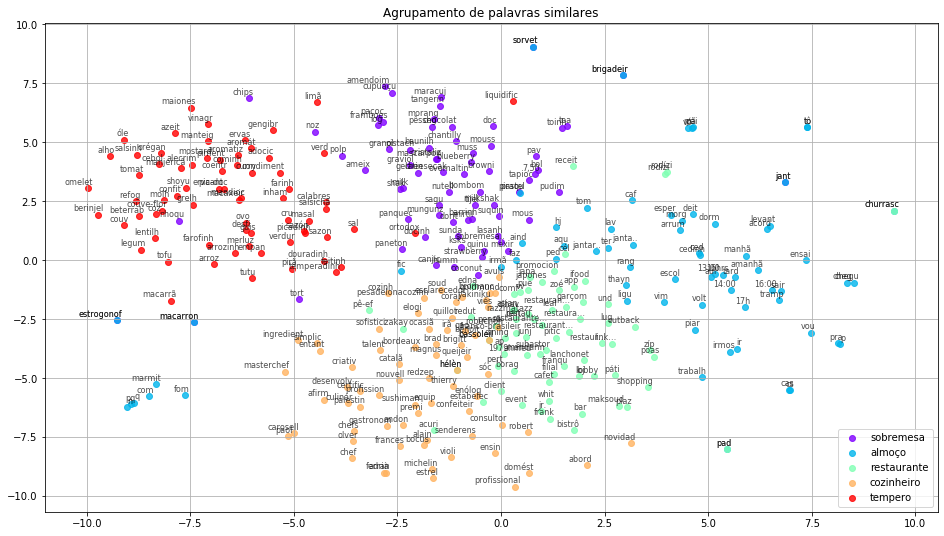

In [94]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


def tsne_plot_similar_words(title, labels, grupos, grupos_de_palavras, a, filename=None):
    plt.figure(figsize=(16, 9))
    cores = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, palavras, cor in zip(labels, grupos, grupos_de_palavras, cores):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=cor, alpha=a, label=label)
        for i, palavra in enumerate(palavras):
            plt.annotate(palavra, alpha=0.7, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Agrupamento de palavras similares', palavras_chave, embeddings_en_2d, grupos_de_palavras, 0.8,
                        'clusters.png')

In [117]:
temp = lista_comparacoes.replace([np.inf, -np.inf], np.nan)
print(temp['semelhança semântica'].mean())
print(temp['distância de edição'].mean())

21.573832669556595
61.8048


In [139]:
lista_intencoes = [[nome_intencao] for nome_intencao in temp['intenção 1'].unique()]

In [140]:
# for nome_intencao in lista_intencoes:
lista_intencoes

[['pedir_recomendacao'],
 ['reservar_mesa'],
 ['consultar_cardapio'],
 ['reclamar_atendimento'],
 ['fazer_pedido'],
 ['elogiar_atendimento'],
 ['cancelar_pedido'],
 ['saudacao'],
 ['consultar_funcionamento'],
 ['despedida']]

In [141]:
temp.set_index('intenção 1')

,intenção 2,exemplo 1,exemplo 2,semelhança semântica,distância de edição
intenção 1,,,,,
pedir_recomendacao,pedir_recomendacao,Você me recomenda algum prato?,Você me recomenda algum prato?,0.000000,0.0
pedir_recomendacao,pedir_recomendacao,Você me recomenda algum prato?,O que você recomenda?,16.430505,32.5
pedir_recomendacao,pedir_recomendacao,Você me recomenda algum prato?,Quais pratos vocês recomendam?,8.747558,39.0
pedir_recomendacao,pedir_recomendacao,Você me recomenda algum prato?,Qual comida você me sugere?,20.300580,54.0
pedir_recomendacao,pedir_recomendacao,Você me recomenda algum prato?,O que tem de mais gostoso pra comer aí?,23.108955,58.0
pedir_recomendacao,pedir_recomendacao,O que você recomenda?,Você me recomenda algum prato?,16.430505,32.5
pedir_recomendacao,pedir_recomendacao,O que você recomenda?,O que você recomenda?,0.000000,0.0
pedir_recomendacao,pedir_recomendacao,O que você recomenda?,Quais pratos vocês recomendam?,16.830851,21.0
pedir_recomendacao,pedir_recomendacao,O que você recomenda?,Qual comida você me sugere?,18.062320,51.0
